In [1]:
import pymc as pm
import numpy as np
import pandas as pd
from scipy import stats
import arviz as az
import matplotlib.pyplot as plt

In [21]:
mu_0 = 0
sigma_0 = 10
sigma_half_norm = 5
low=1
high=101


# True values that the data will be from, IRL, we don't knnow these values
n,loc_true,scale_true,df_true = 100,10,2,15
# Generate observations
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n)

model = pm.Model()

with model:
    loc = pm.Normal("loc", mu = mu_0, sigma = sigma_0)
    scale = pm.HalfNormal("scale", sigma = sigma_half_norm)
    df = pm.DiscreteUniform("df", lower = low, upper = high)
    x_obs = pm.StudentT("likelihood", mu = loc, sigma = scale, nu = df, observed=x)

In [22]:
with model:
    idata_HMC = pm.sample()

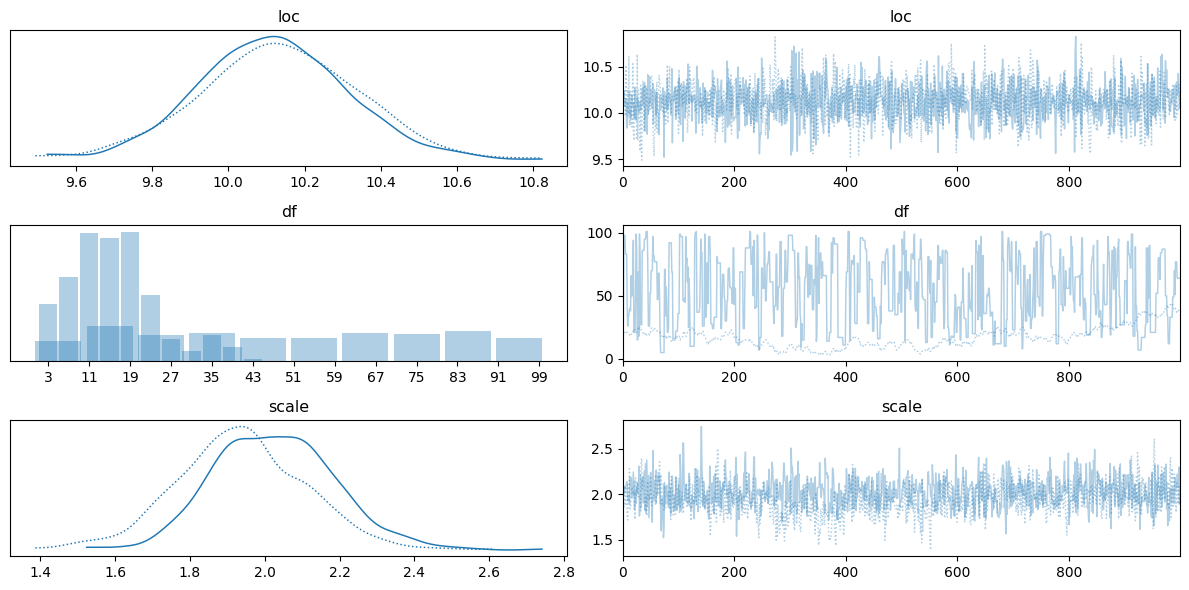

In [23]:
az.plot_trace(idata_HMC)
plt.tight_layout()

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

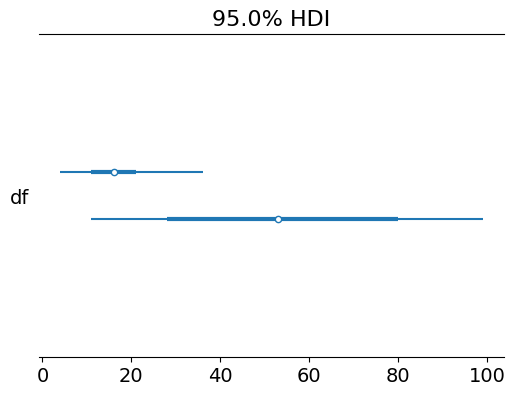

In [24]:
az.plot_forest(idata_HMC, var_names=["df"], combined=False, hdi_prob=0.95)

In [25]:
print("Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()})

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Split-Rhats {'loc': 1.0004, 'df': 1.4213, 'scale': 1.0608}


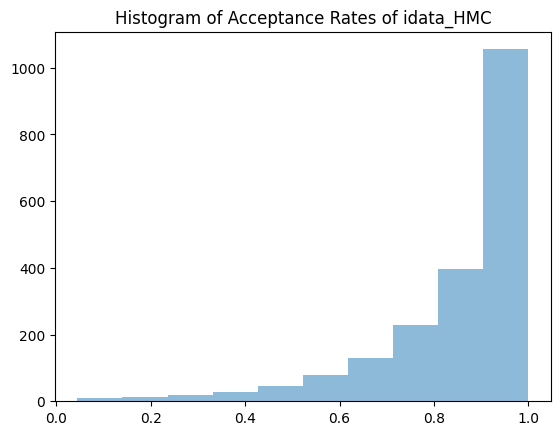

In [40]:
plt.hist(idata_HMC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,);
plt.title('Histogram of Acceptance Rates of idata_HMC');

Autocorrelation for HMC (MCMC) chain 0.6844028812855082


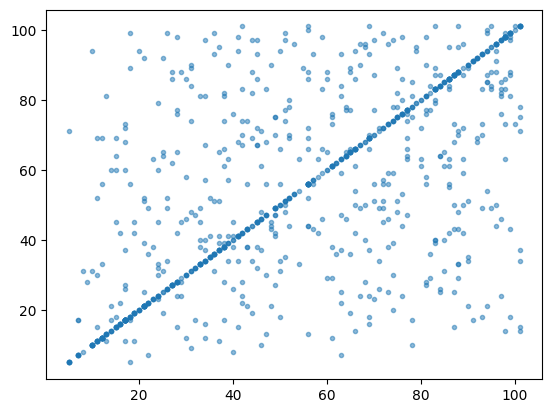

In [27]:
fig,ax = plt.subplots(1,1)
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["df"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values;
mcmc_chain_one_step_ahead = idata_HMC.posterior["df"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values
ax.plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

There is a significant amount of uncertainty in the df parameter. In our df plot we seem to be coming close to the true value as shown by the cluster of values between 11-19. However, our split-R values are well above 1.05, thus showing we are not converging toward a stationary distribution. Furthermore, our autocorrelation is quite high, implying that we are not increasing our effective sample size. Finally, within our 95% HDI plot, we see two significantly different centered values. The result of these pieces of information is that we would need a larger sample size to appropriately discern the value for the df parameter.

Testing 100000 samples

In [32]:
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(1000)

with model:
    idata_HMC = pm.sample()

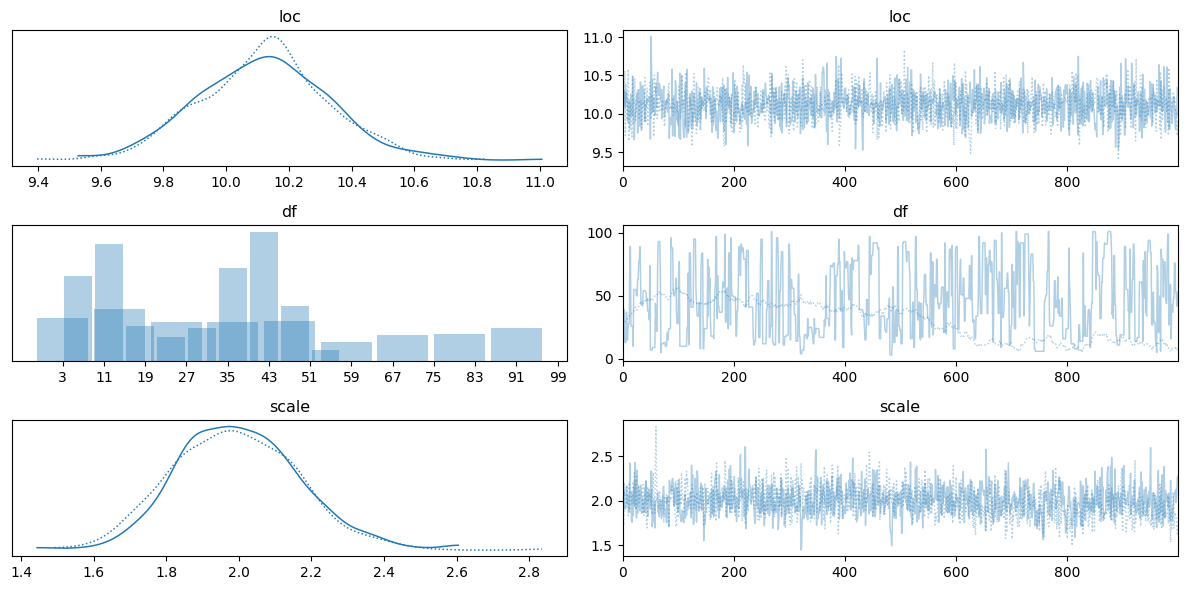

In [33]:
az.plot_trace(idata_HMC)
plt.tight_layout()

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

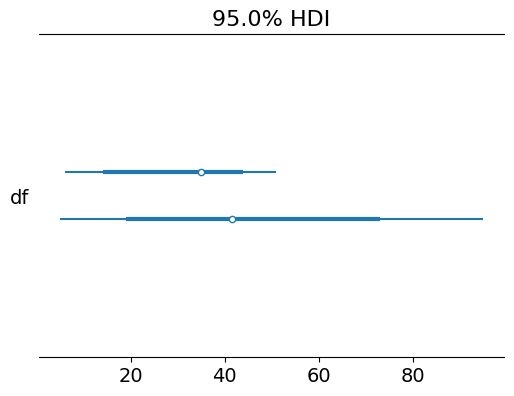

In [34]:
az.plot_forest(idata_HMC, var_names=["df"], combined=False, hdi_prob=0.95)

In [35]:
print("Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()})

Split-Rhats {'loc': 1.0008, 'df': 1.2266, 'scale': 1.0366}


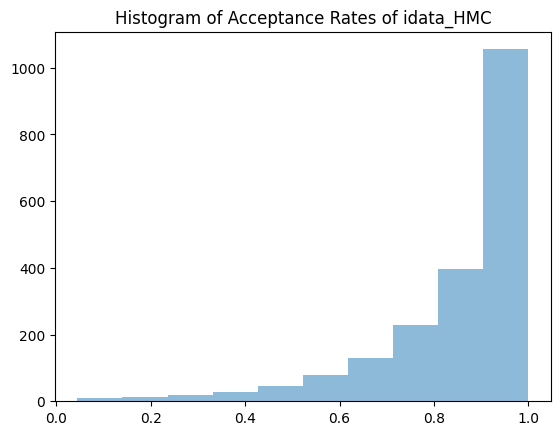

In [41]:
plt.hist(idata_HMC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,);
plt.title('Histogram of Acceptance Rates of idata_HMC');

Autocorrelation for HMC (MCMC) chain 0.6901069790057969


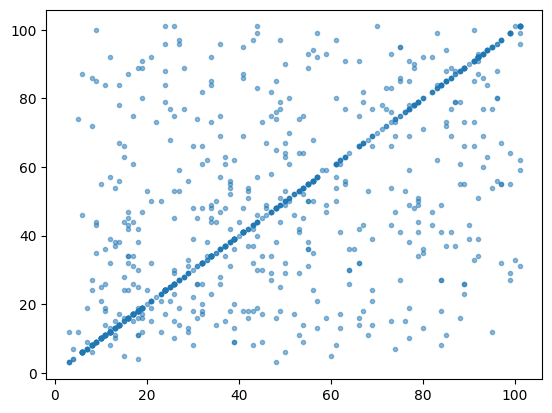

In [36]:
fig,ax = plt.subplots(1,1)
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["df"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values;
mcmc_chain_one_step_ahead = idata_HMC.posterior["df"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values
ax.plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

We can see our results get better in certain ways but not by a significant margin as a result of increasing sample sizes. Autocorrelation remains quite similar and our estimate for the parameter has actually become worse in accuracy. Our split-R score is better but not to the level that we could suggest convergence. More testing and a higher sample size would be needed to improve the df parameter.

In [42]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

# Set up the model
with pm.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # Note that if tau was small, then the density evalution above
    # could change rapidly for changes in theta
    # This means that the energy has high curvature

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

In [43]:
# Conduct PyMC simulation
SEED = [20100420, 20134234] # random seeds for each of two run HMC chains
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

In [44]:
print("number of MCMC samples:", fit_C.posterior['mu'].values.flatten().shape[-1])
az.summary(fit_C, round_to=2)

number of MCMC samples: 10000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.30,3.39,-1.98,10.55,0.14,0.10,622.77,372.14,1.01
theta[0],6.60,6.25,-3.97,19.07,0.22,0.16,538.46,1066.22,1.01
theta[1],5.01,5.07,-4.28,14.87,0.15,0.10,978.36,2058.62,1.00
theta[2],3.68,5.66,-7.11,14.17,0.12,0.09,1575.05,3789.16,1.00
theta[3],4.76,5.13,-5.04,14.36,0.15,0.11,964.74,3571.47,1.00
theta[4],3.36,5.07,-6.59,12.71,0.12,0.09,1673.49,2949.01,1.00
theta[5],3.85,5.12,-5.84,13.58,0.11,0.08,1769.35,3374.08,1.00
theta[6],6.71,5.47,-2.65,17.48,0.25,0.17,415.23,977.87,1.01
theta[7],4.86,5.70,-5.74,16.01,0.13,0.09,1248.42,3856.95,1.00
tau,4.30,3.31,0.84,10.22,0.17,0.12,128.66,95.34,1.02


In [45]:
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(fit_C).items()})

HMC Split-Rhats {'mu': 1.0055, 'theta': array([1.0065, 1.0039, 1.0032, 1.0046, 1.0017, 1.0035, 1.006 , 1.0024]), 'tau': 1.0226}


Our split-R values are all below 1.05, suggesting convergence

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

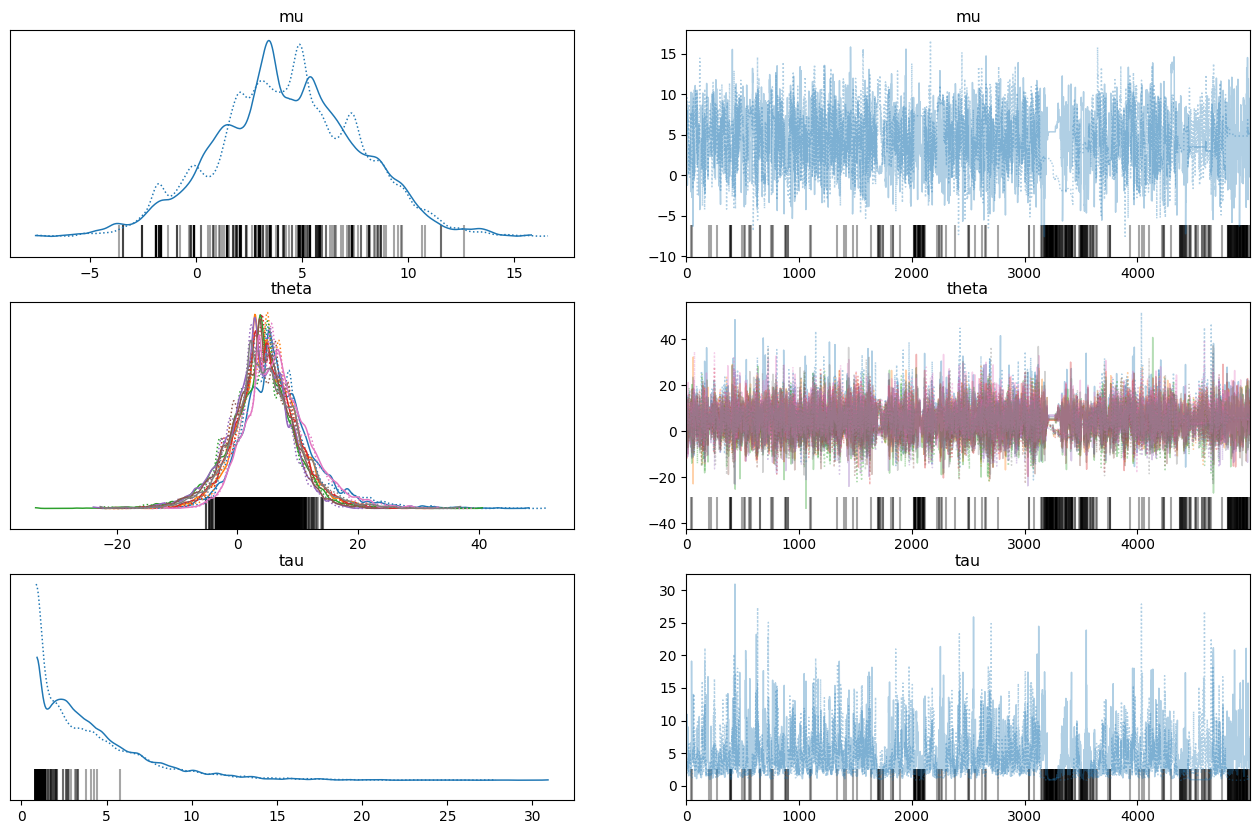

In [46]:
fig,ax = plt.subplots(3,2, figsize=(16,10))
az.plot_trace(fit_C, axes=ax[:3,:3])

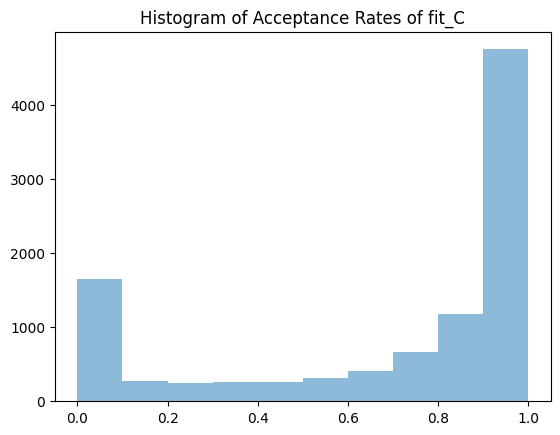

In [47]:
plt.hist(fit_C.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,);
plt.title('Histogram of Acceptance Rates of fit_C');

In [49]:
with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations
    # below so the energy still has high curvature with respect to tau; but,
    # it no longer has high curvature with respect to theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

In [50]:
with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'theta_t'}>,
        <Axes: title={'center': 'theta_t'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

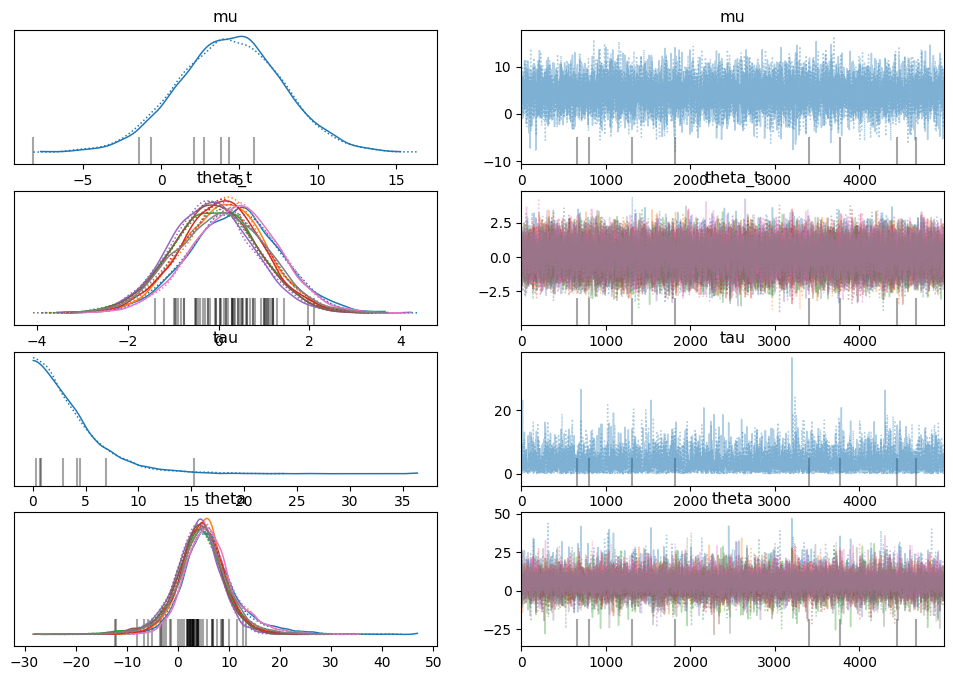

In [57]:
az.plot_trace(fit_NC)

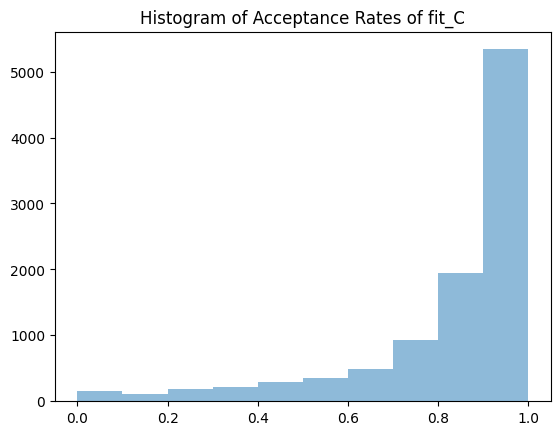

In [54]:
plt.hist(fit_NC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,);
plt.title('Histogram of Acceptance Rates of fit_C');

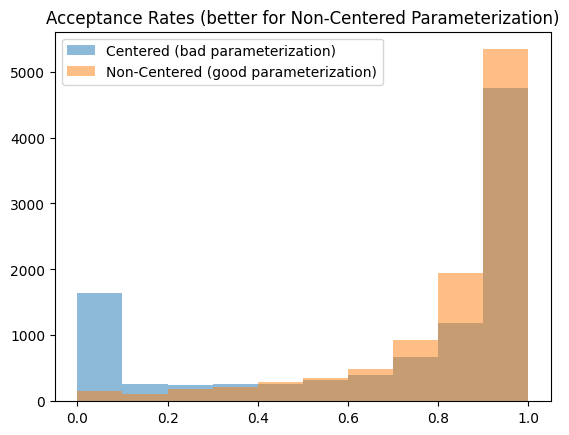

In [51]:
import matplotlib.pyplot as plt
plt.hist(fit_C.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Centered (bad parameterization)');
plt.hist(fit_NC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Non-Centered (good parameterization)');
plt.title('Acceptance Rates (better for Non-Centered Parameterization)'); plt.legend();

In [52]:
import pandas as pd
print("Effective Sample Sizes (function of Markov Chain autocorrelation dependency)")
pd.concat(
[pd.DataFrame({'Centered': pm.summary(fit_C)[:1]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][:1]}),
 pd.DataFrame({'Centered': pm.summary(fit_C)[1:]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][9:]})])


Effective Sample Sizes (function of Markov Chain autocorrelation dependency)


,Centered,Non-Centered
mu,623.0,11120.0
tau,129.0,5121.0
theta[0],538.0,10859.0
theta[1],978.0,11965.0
theta[2],1575.0,11071.0
theta[3],965.0,12523.0
theta[4],1673.0,11294.0
theta[5],1769.0,10616.0
theta[6],415.0,11073.0
theta[7],1248.0,11415.0


The uncentered performs better than the centered in terms of effective sample size as can be seen above for every parameter. What this suggests is that in the uncentered model the autocorrelation is significantly lower

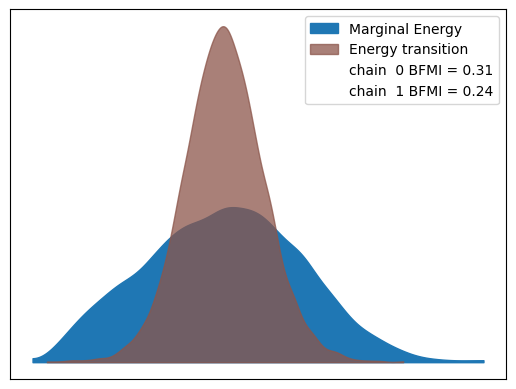

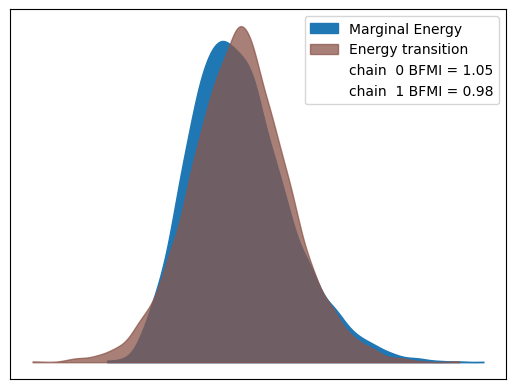

In [53]:
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

The energy function supports my previous conclusion regarding sample sizes for the uncentered versus centered models. This is due to the fact that in the uncentered model, changes in theta now take place on a fixed scale that is independent of tau. By removing the dependence between the two parameters, changes in each parameter do not affect one another, and thus, the autocorrelation is not nearly as high between the two. This can be seen in the energy function which demonstrates a much more similar plot between marginal energy and energy transition when compared to the centered model.